# Tesi-RL

## LIBs

In [1]:
import gym
from gym import spaces
import numpy as np
import random
import logging
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import math

from tensorflow.keras.layers import Dense, Input, Concatenate, LeakyReLU, BatchNormalization, Lambda, Add, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.summary import create_file_writer

from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tf.keras.__version__)
print("Gym version: ", gym.__version__)
print("Numpy version: ", np.__version__)

#print the python version

import sys
print("Python version: ", sys.version)

Tensorflow version:  2.12.0
Keras version:  2.12.0
Gym version:  0.26.2
Numpy version:  1.23.5
Python version:  3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


## ENV

This implementation still describes a non-real scenario with some simplifying assumptions.

The current environment is implemented with the following logic:
- At each new episode, the environment is reset with a 0 load. CPU_capacity (i.e., our local processing capacity) is maximum (=50), the available queue is maximum (=100), and requests to be processed are generated according to a sine function that is distributed around 100 (min 50, max 150, period = 99). 
- At present, the generation of requests is based on a strong simplifying assumption: the requests all require the same CPU_capacity and their numerical generation simply represents how many requests I need to process at each step.
- A step ends when the queue fills up, which is equivalent to saying that the system has become congested
- At the end of each step the updated CPU_capacity and available queue capacity values are passed into the `state`, along with the number of requests to process at the next step.
- We want the agent to favor local processing unless the queue is filling up. In that case to avoid congestion the agent will have to forward the requests.

This function processes the values of the actions generated by the actor network in the following way:
- adds a very small amount to the sum of the actions in the rare case where their sum was 0. This step is relevant because the sum of the actions is normalized and if it were 0 would result in nan
- the integer value of the number of locally processed, forwarded, and rejected actions is calculated and the remaining request that was present in the decimal part is assigned to the one of the 3 actions that had a larger decimal part. The operation of calculating how many requests were processed, forwarded, and rejected is important because we will use these values in the reward system. In addition, the final activation of the actor network is a softmax, so we need to multiply those decimal sum-1 values by the number of input_requests to be processed in that step.

In [2]:
def process_actions(action, input_requests):
    action_sum = np.sum(action)
    if action_sum == 0:
        action_sum += 1e-8
    action /= action_sum

    local = int(action[0] * input_requests)
    local_fraction = (action[0] * input_requests) - local
    forwarded = int(action[1] * input_requests)
    forwarded_fraction = (action[1] * input_requests) - forwarded
    rejected = int(action[2] * input_requests)
    rejected_fraction = (action[2] * input_requests) - rejected
    total_actions = local + forwarded + rejected

    if total_actions < input_requests:
        fractions = [local_fraction, forwarded_fraction, rejected_fraction]
        actions = [local, forwarded, rejected]
        max_fraction_index = np.argmax(fractions)
        actions[max_fraction_index] += input_requests - total_actions
        local, forwarded, rejected = actions

    return local, forwarded, rejected

The reward system is defined in the following way:
- the more the buffer queue is empty, the more we press local processing
- the more the buffer queue fills, the more we reward forwarding to other edge nodes (currently not implemented in the environment)
- the more the buffer queue fills, the less we penalize rejection

To implement this logic we defined the variable `QUEUE_factor`, which takes values from 0 to 1 and is used as a weight for rewards.

In [3]:
def calculate_reward1(local, forwarded, rejected, QUEUE_factor):
    reward_local = 2 * local * QUEUE_factor
    reward_forward = forwarded * (1 - QUEUE_factor)
    reward_reject = -3 * rejected * QUEUE_factor
    reward = reward_local + reward_forward + reward_reject
    return reward

In [4]:
class TrafficManagementEnv(gym.Env):
    def __init__(self, CPU_capacity=50, buffer_queue_capacity = 100, queue_length = 0, average_requests = 100, amplitude_requests = 50, period=99):
        super().__init__()

        self.action_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float64)
        self.observation_space = spaces.Box(low=np.array([50, -100, 0]), high=np.array([150, 50, 100]), dtype=np.float64)

        self.max_CPU_capacity = CPU_capacity
        self.CPU_capacity = self.max_CPU_capacity
        self.max_buffer_queue_capacity = buffer_queue_capacity
        self.buffer_queue_capacity = self.max_buffer_queue_capacity

        self.average_requests = average_requests
        self.amplitude_requests = amplitude_requests
        self.period = period
        self.t = 0

        self.queue_length = queue_length
        self.input_requests = self.calculate_requests()
        

    def calculate_requests(self):
        return int(self.average_requests + self.amplitude_requests * math.sin(2*math.pi*self.t/self.period))
    
    def reset(self):
        self.CPU_capacity = self.max_CPU_capacity
        self.buffer_queue_capacity = self.max_buffer_queue_capacity
        self.queue_length = 0
        self.t = 0
        return np.array([self.input_requests, self.CPU_capacity, self.buffer_queue_capacity],  dtype=np.float64)

    def step(self, action):
        print(f"INPUT: {self.input_requests}")
        print(f"CPU Capacity: {self.CPU_capacity}")
        print(f"Lunghezza Coda: {self.queue_length}")

        self.local, self.forwarded, self.rejected = process_actions(action, self.input_requests)

        print(f"LOCAL: {self.local}")
        print(f"FORWARDED: {self.forwarded}")
        print(f"REJECTED: {self.rejected}")

        self.QUEUE_factor = self.buffer_queue_capacity / self.max_buffer_queue_capacity

        reward = calculate_reward1(self.local, self.forwarded, self.rejected, self.QUEUE_factor)

        print(f"REWARD: {reward}")

        self.queue_length = max(0, self.local - self.CPU_capacity)
        self.CPU_capacity = max(-100,self.max_CPU_capacity - self.queue_length)
        self.buffer_queue_capacity = max(0,self.max_buffer_queue_capacity - self.queue_length)

        done = self.buffer_queue_capacity <= 0

        info = {
            'input_requests': self.input_requests,
            'requests_handled_locally': self.local,
            'requests_forwarded': self.forwarded,
            'requests_rejected': self.rejected,
            'QUEUE_factor': self.QUEUE_factor,
            'queue_length': self.queue_length,
        }

        self.t += 1
        self.input_requests = self.calculate_requests()

        state = np.array([self.input_requests, self.CPU_capacity, self.buffer_queue_capacity],  dtype=np.float64)

        return state, reward, done, info

Given the deterministic nature of DDPG that will be implemented later, OU noise has been introduced that will change the output of the actor network to favor exploration.

The noise will start from a fairly high sigma value (0.30) and then decay as episodes pass.

In [5]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, size, seed = 123, mu=0.0, theta=0.15, sigma=0.30, decay_rate=0.9999):   #, decay_rate=0.99995
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.decay_rate = decay_rate
        self.state = np.ones(self.size) * self.mu

        np.random.seed(seed)

    def reset(self):
        self.state = np.ones(self.size) * self.mu
        
    def decay(self):
        self.sigma *= self.decay_rate

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

## DDPG

Tensorflow implementation of the Deep Deterministic Policy Gradient algorithm.  
The parameters were not tuned with some specific technique, but just chosen based on many training attempts.

In [6]:
class DDPG:
    def __init__(self, env, lr_actor=0.0001, lr_critic=0.001, gamma=0.9, tau=0.005):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.noise = OrnsteinUhlenbeckNoise(env.action_space.shape[0])

        self.actor = self.build_actor()
        self.target_actor = self.build_actor()
        self.target_actor.set_weights(self.actor.get_weights())

        self.critic = self.build_critic()
        self.target_critic = self.build_critic()
        self.target_critic.set_weights(self.critic.get_weights())

        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.critic_optimizer = Adam(learning_rate=lr_critic)

    def build_actor(self):
        inputs = Input(shape=self.env.observation_space.shape)
        x = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(inputs) # , kernel_initializer='he_normal'
        x = BatchNormalization()(x)
        x = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(x) # , kernel_initializer='he_normal'
        x = BatchNormalization()(x)
        x = Dense(self.env.action_space.shape[0], activation='sigmoid')(x)
        return Model(inputs, x)

    def build_critic(self):
        state_inputs = Input(shape=self.env.observation_space.shape)
        action_inputs = Input(shape=self.env.action_space.shape)
        x = Concatenate()([state_inputs, action_inputs])
        x = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(x)
        #x = BatchNormalization()(x)
        x = Dense(64, activation='tanh', kernel_regularizer=l2(0.01))(x)
        #x = BatchNormalization()(x)
        x = Dense(1, activation=None)(x)
        return Model([state_inputs, action_inputs], x)

    def act(self, state):
        state = np.expand_dims(state, axis=0)
        action = self.actor(state).numpy()[0]
        action += self.noise.sample()
        return np.clip(action, self.env.action_space.low, self.env.action_space.high)

    def train(self, replay_buffer, batch_size=64):
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        target_actions = self.target_actor(next_states)
        target_q_values = self.target_critic([next_states, target_actions])
        target_q_values = rewards + (1 - dones) * self.gamma * target_q_values

        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean((q_values - target_q_values) ** 2)
        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            actions = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic([states, actions]))
        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        self.soft_update(self.target_actor, self.actor)
        self.soft_update(self.target_critic,self.critic)

        return actor_loss.numpy(), critic_loss.numpy()

    def soft_update(self, target_model, model):
        for target_var, var in zip(target_model.trainable_variables, model.trainable_variables):
            target_var.assign((1 - self.tau) * target_var + self.tau * var)
    
    def save_weights(self, path):
        self.actor.save_weights(path + '_actor.h5')
        self.critic.save_weights(path + '_critic.h5')

    def load_weights(self, path):
        self.actor.load_weights(path + '_actor.h5')
        self.critic.load_weights(path + '_critic.h5')

implementation of the Replay Buffer from which the experiences will be sampled

In [7]:
class ReplayBuffer:
    def __init__(self, buffer_size=200000):
        self.buffer = []
        self.buffer_size = buffer_size

    def store(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append([state, action, reward, next_state, done])
        print(f"Buffer length: {len(self.buffer)}")

    def sample(self, batch_size):
        samples = np.array(random.sample(self.buffer, batch_size))
        return (
            np.stack(samples[:, 0]),
            np.stack(samples[:, 1]),
            samples[:, 2].astype(float),
            np.stack(samples[:, 3]),
            samples[:, 4].astype(float),
        )

## Training

A maximum of 50 steps per episode is set in order not to make training infinite in case the agent obtains the optimal policy.

In [8]:
def train_ddpg_agent(env, agent, num_episodes=5000, max_steps_per_episode=50, buffer_size=200000, batch_size=64, warm_up=1024):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/ddpg/' + current_time
    summary_writer = tf.summary.create_file_writer(train_log_dir)

    replay_buffer = ReplayBuffer(buffer_size)
    steps = 0
    total_reward = []
    steps_reward = []
    actor_losses = []
    critic_losses = []
    exploration_rates=[]

    for episode in range(num_episodes):
        state = env.reset()
        agent.noise.reset()
        episode_reward = 0
        actor_loss = 0
        critic_loss = 0

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.store(state, action, reward, next_state, done)

            if steps > warm_up:
                actor_loss_step, critic_loss_step = agent.train(replay_buffer, batch_size)
                actor_loss += actor_loss_step
                critic_loss += critic_loss_step

                with summary_writer.as_default():  # log losses and reward
                    tf.summary.scalar('actor_loss', actor_loss, step=steps)
                    tf.summary.scalar('critic_loss', critic_loss, step=steps)
                    tf.summary.scalar('episode_reward', episode_reward, step=steps)
                    tf.summary.scalar('exploration_rate', agent.noise.sigma, step=steps)

            state = next_state
            episode_reward += reward
            steps_reward.append(reward)
            steps += 1
            agent.noise.decay()

            if done:
                break

        print(f"Episode {episode + 1}, Reward: {episode_reward}, Steps: {steps}")
        logging.info(f"Episode {episode + 1}, Reward: {episode_reward}, Steps: {steps}")
        
        agent.save_weights("C:/Users/giaco/Desktop/tesi-git/Pesi reti")

        actor_losses.append(actor_loss / max_steps_per_episode if step > 0 else actor_loss)
        critic_losses.append(critic_loss / max_steps_per_episode if step > 0 else critic_loss)
        exploration_rates.append(agent.noise.sigma)
        total_reward.append(episode_reward)

    steps_metrics = pd.DataFrame({
        'Rewards Steps': steps_reward
    })
    steps_metrics.to_csv('steps_metrics.csv')
    
    metrics = pd.DataFrame({
        'Rewards Episodi': total_reward,
        'actor_losses': actor_losses,
        'critic_losses': critic_losses,
        'exploration_rates': exploration_rates
    })

    metrics.to_csv('training_metrics.csv')

    plt.plot(steps_reward)
    plt.xlabel('Episode')
    plt.ylabel('Reward di ogni step')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Reward di ogni episodio')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(actor_losses)
    plt.xlabel('Training Steps')
    plt.ylabel('ActorLoss')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(critic_losses)
    plt.xlabel('Training Steps')
    plt.ylabel('CriticLoss')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(exploration_rates)
    plt.xlabel('Training Steps')
    plt.ylabel('Exploration Rate')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()
    plt.show()

c:\Users\giaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


INPUT: 100
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 25
FORWARDED: 38
REJECTED: 37
REWARD: -61.0
Buffer length: 1
INPUT: 103
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 3
FORWARDED: 35
REJECTED: 65
REWARD: -189.0
Buffer length: 2
INPUT: 106
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 0
FORWARDED: 29
REJECTED: 77
REWARD: -231.0
Buffer length: 3
INPUT: 109
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 0
FORWARDED: 16
REJECTED: 93
REWARD: -279.0
Buffer length: 4
INPUT: 112
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 0
FORWARDED: 0
REJECTED: 112
REWARD: -336.0
Buffer length: 5
INPUT: 115
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 0
FORWARDED: 48
REJECTED: 67
REWARD: -201.0
Buffer length: 6
INPUT: 118
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 22
FORWARDED: 42
REJECTED: 54
REWARD: -118.0
Buffer length: 7
INPUT: 121
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 46
FORWARDED: 24
REJECTED: 51
REWARD: -61.0
Buffer length: 8
INPUT: 124
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 36
FORWARDED: 17
REJECTED: 71
REWA

C:\Users\giaco\AppData\Local\Temp\ipykernel_4060\1947288514.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(random.sample(self.buffer, batch_size))


INPUT: 147
CPU Capacity: -45
Lunghezza Coda: 95
LOCAL: 67
FORWARDED: 25
REJECTED: 55
REWARD: 22.2
Buffer length: 1028
Episode 64, Reward: -743.7099999999998, Steps: 1028
INPUT: 148
CPU Capacity: 50
Lunghezza Coda: 0
LOCAL: 73
FORWARDED: 69
REJECTED: 6
REWARD: 128.0
Buffer length: 1029
INPUT: 103
CPU Capacity: 27
Lunghezza Coda: 23
LOCAL: 55
FORWARDED: 30
REJECTED: 18
REWARD: 50.02000000000001
Buffer length: 1030
INPUT: 106
CPU Capacity: 22
Lunghezza Coda: 28
LOCAL: 68
FORWARDED: 31
REJECTED: 7
REWARD: 91.48
Buffer length: 1031
INPUT: 109
CPU Capacity: 4
Lunghezza Coda: 46
LOCAL: 47
FORWARDED: 62
REJECTED: 0
REWARD: 79.28
Buffer length: 1032
INPUT: 112
CPU Capacity: 7
Lunghezza Coda: 43
LOCAL: 62
FORWARDED: 41
REJECTED: 9
REWARD: 72.92
Buffer length: 1033
INPUT: 115
CPU Capacity: -5
Lunghezza Coda: 55
LOCAL: 89
FORWARDED: 26
REJECTED: 0
REWARD: 94.4
Buffer length: 1034
INPUT: 118
CPU Capacity: -44
Lunghezza Coda: 94
LOCAL: 39
FORWARDED: 53
REJECTED: 26
REWARD: 49.82
Buffer length: 1035


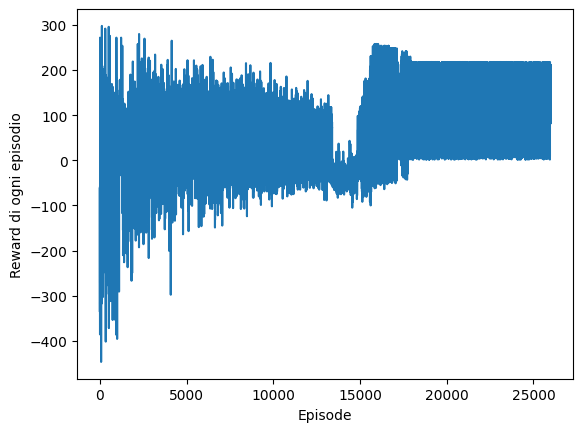

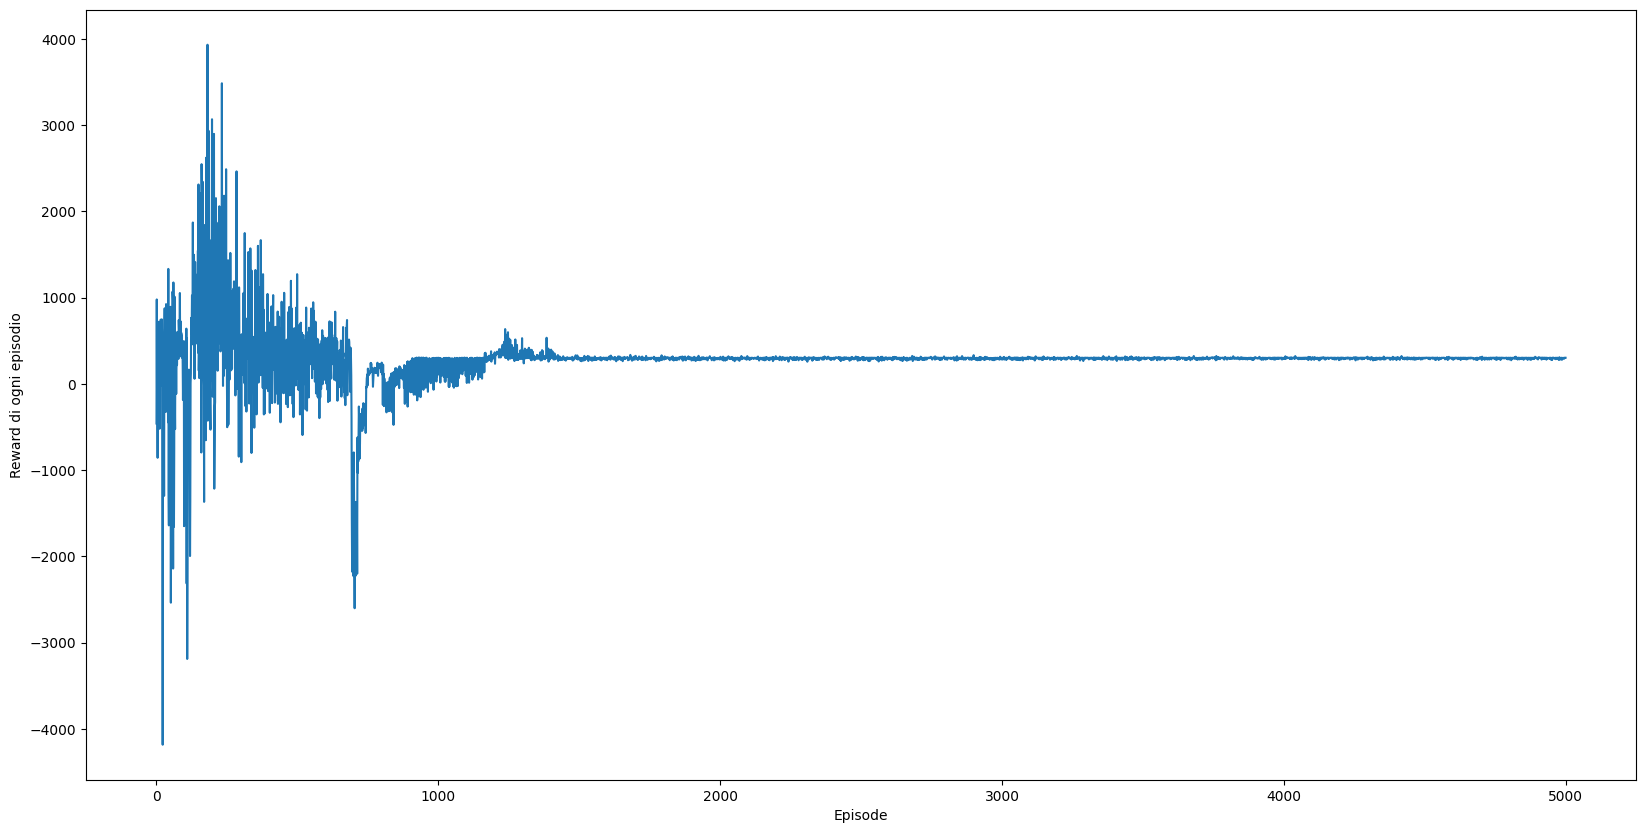

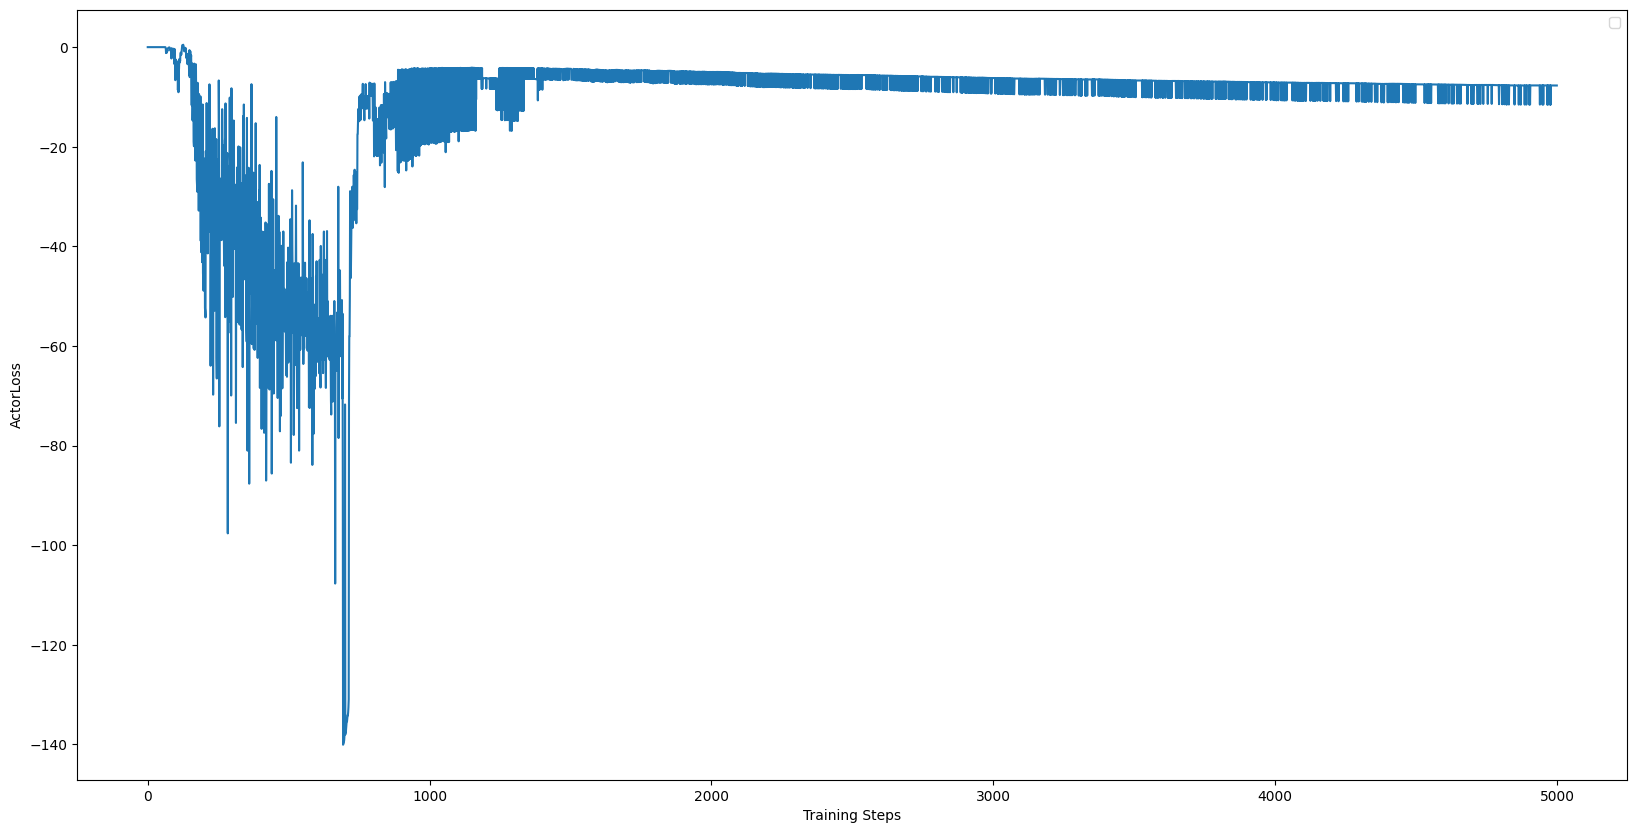

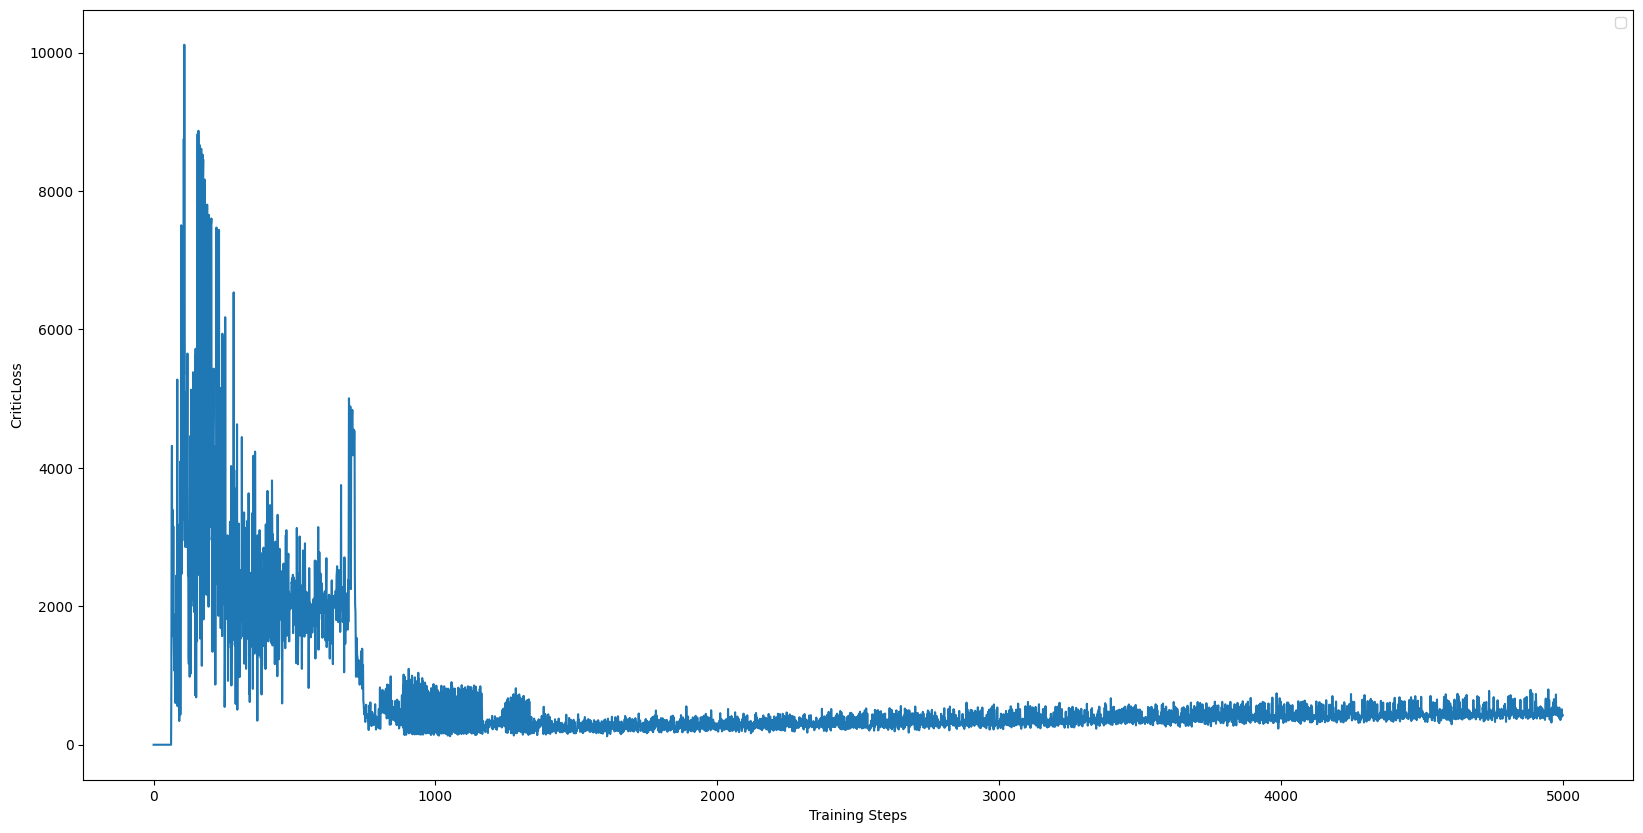

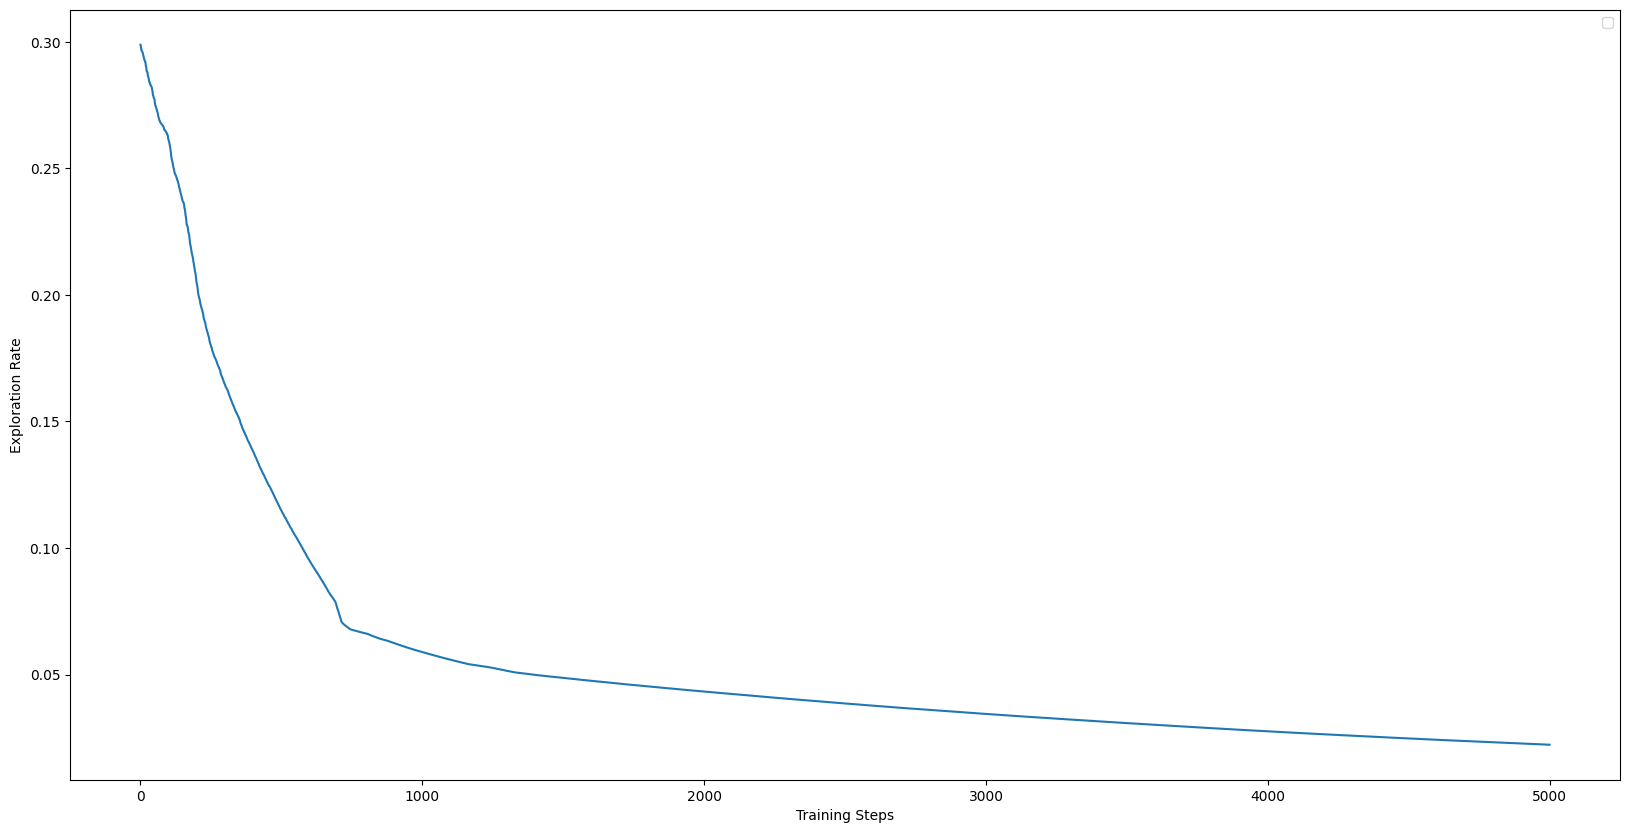

In [9]:
if __name__ == "__main__":
    env = TrafficManagementEnv()
    agent = DDPG(env)
    train_ddpg_agent(env, agent)

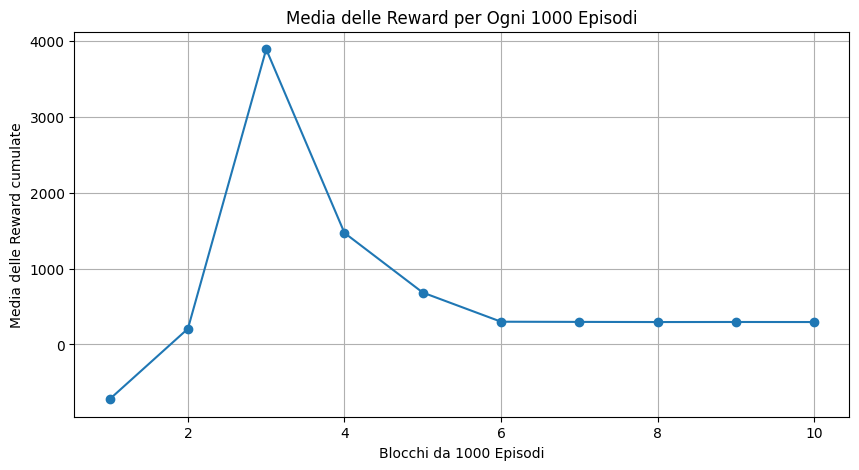

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('training_metrics.csv')

rewards = df['Reward di ogni episodio'].values

means = []
for i in range(0, len(rewards), 100):
    means.append(np.mean(rewards[i:i+100]))

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(means) + 1), means, marker='o')
plt.title('Media delle Reward per Ogni 100 Episodi')
plt.xlabel('Blocchi da 100 Episodi')
plt.ylabel('Episodes Rewards')
plt.grid(True)
plt.show()

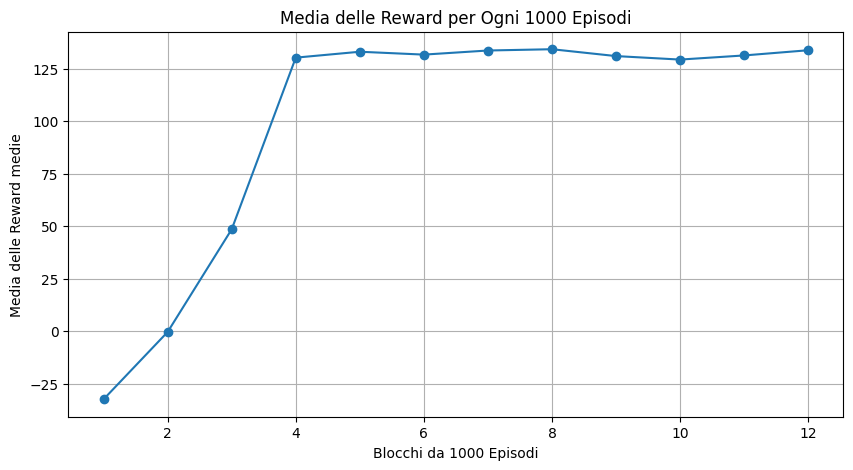

In [ ]:
stepsrewards = df['Rewards Steps'].values

stepsrw = []
for i in range(0, len(stepsrewards), 10):
    stepsrw.append(np.mean(stepsrewards[i:i+10]))

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(stepsrw) + 1), stepsrw, marker='o')
plt.title('Media delle Rewards ogni 10 steps')
plt.xlabel('Blocchi da 10 Episodi')
plt.ylabel('Steps Rewards')
plt.grid(True)
plt.show()